# Vertex AI - Experiments > Studies
## Using Vertex Vizier

---
## Setup

In [123]:
from google.cloud import aiplatform_v1beta1 as aipv1
import numpy as np
import matplotlib.pyplot as plt

In [124]:
# Locations
REGION = 'us-central1'
PROJECT_ID='statmike-mlops'

ENDPOINT = REGION + "-aiplatform.googleapis.com"
PARENT ="projects/{}/locations/{}".format(PROJECT_ID, REGION)

In [141]:
vizier = aipv1.VizierServiceClient(
    client_options = {"api_endpoint" : ENDPOINT}
)

---
## Challenge

In [142]:
r = np.linspace(0,1,100)
theta = np.linspace(0,np.pi/2,100)

R, THETA = np.meshgrid(r, theta)

In [143]:
y1 = R * np.sin(THETA)
y2 = R * np.cos(THETA)

<function matplotlib.pyplot.show(close=None, block=None)>

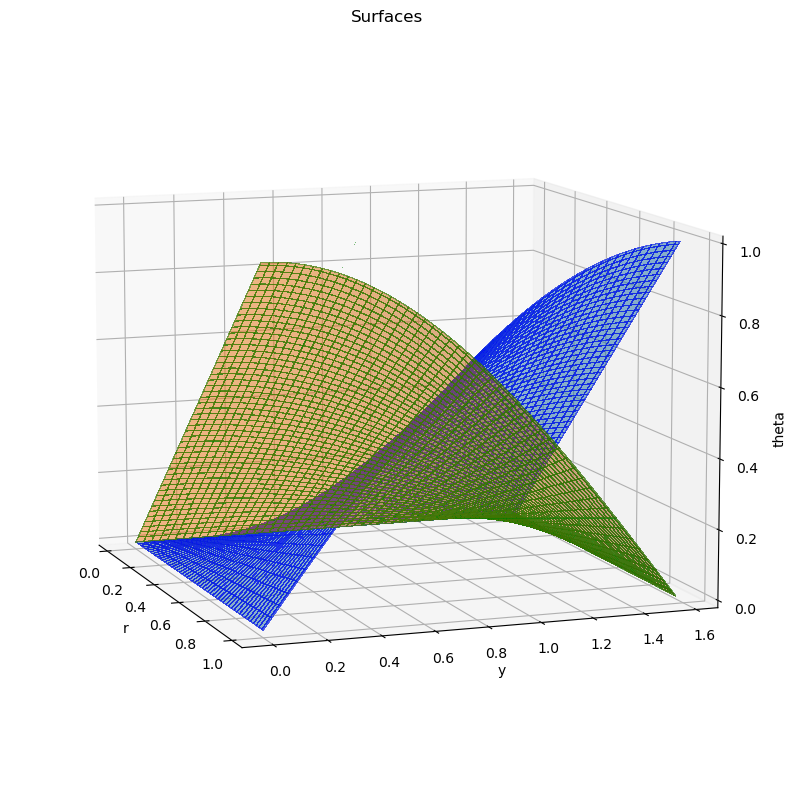

In [144]:
fig = plt.figure(figsize=(10,10), dpi=100)
ax = plt.axes(projection="3d")
ax.plot_surface(R, THETA, y1, rstride=2, cstride=2, alpha=0.5, antialiased=False, shade=True, linewidth=0.1, edgecolor='blue')
ax.plot_surface(R, THETA, y2, rstride=2, cstride=2, alpha=0.5, antialiased=False, shade=True, linewidth=0.1, edgecolor='green')
ax.set_xlabel('r')
ax.set_ylabel('y')
ax.set_zlabel('theta')
ax.set_title('Surfaces')
ax.view_init(10,-20)
plt.show

## Study

In [145]:
study_spec = {
    "display_name" : "CustomOptimization",
    "study_spec" : {
        "algorithm" : "RANDOM_SEARCH",
        "parameters" : [
            {
                "parameter_id" : "r",
                "double_value_spec" : {
                    "min_value" : np.min(r),
                    "max_value" : np.max(r)
                }
            },
            {
                "parameter_id" : "theta",
                "double_value_spec" : {
                    "min_value" : np.min(theta),
                    "max_value" : np.max(theta)
                }
                
            }
        ],
        "metrics" : [
            {
                "metric_id" : "y1",
                "goal" : "MINIMIZE"
            },
            {
                "metric_id" : "y2",
                "goal" : "MAXIMIZE" 
            }
        ]
    }
}
study = vizier.create_study(parent=PARENT, study=study_spec)

In [146]:
study.name, study.display_name

('projects/691911073727/locations/us-central1/studies/2178544715658',
 'CustomOptimization')

## Evaluations

In [147]:
def y1_eval(r,theta):
    return r*np.sin(theta)
def y2_eval(r,theta):
    return r*np.cos(theta)
def metrics(trial, r, theta):
    y1 = y1_eval(r,theta)
    y2 = y2_eval(r,theta)
    m1 = {"metric_id" : "y1", "value" : y1}
    m2 = {"metric_id" : "y2", "value" : y2}
    return [m1, m2]

## Trials

In [148]:
trial_id = 0
while int(trial_id) < 100:
    suggestions = vizier.suggest_trials(
        {
            "parent": study.name,
            "suggestion_count" : 5,
            "client_id" : "client1"
        }
    )
    
    for suggestion in suggestions.result().trials:
        trial_id = suggestion.name.split("/")[-1]
        trial = vizier.get_trial({"name" : suggestion.name})
        
        if trial.state in ["COMPLETED", "INFEASIBLE"]:
            continue
        
        for param in trial.parameters:
            if param.parameter_id == "r": 
                r = param.value
            elif param.parameter_id == "theta":
                theta = param.value
        
        vizier.add_trial_measurement(
            {
                "trial_name": suggestion.name,
                "measurement": {
                    "metrics": metrics(suggestion.name, r, theta)
                }               
            }
        )
        
        response = vizier.complete_trial(
            {
                "name" : suggestion.name,
                "trial_infeasible": False
            }
        )

trial_id is 1, r is 0.4337438710885903, theta is 1.4055437767436156
trial_id is 2, r is 0.8112262637000024, theta is 0.6568173627288989
trial_id is 3, r is 0.3542813374026556, theta is 0.00034604450298658933
trial_id is 4, r is 0.24406910094742265, theta is 1.431990512673356
trial_id is 5, r is 0.15977190904354724, theta is 0.7677084868315671
trial_id is 6, r is 0.719268399952976, theta is 0.5806170894500575
trial_id is 7, r is 0.7636564199452224, theta is 1.2275900530745472
trial_id is 8, r is 0.35807977155018217, theta is 0.49725620222288724
trial_id is 9, r is 0.6652496902608406, theta is 1.3733731734736747
trial_id is 10, r is 0.2298879170687427, theta is 0.34931830966117433
trial_id is 11, r is 0.9067324147176448, theta is 0.2578129613859345
trial_id is 12, r is 0.11879191269537388, theta is 0.347281744051994
trial_id is 13, r is 0.19606862147804763, theta is 1.1045226150684606
trial_id is 14, r is 0.9842297600535865, theta is 0.03251279062446233
trial_id is 15, r is 0.05221172456

## Answers

In [149]:
trials = vizier.list_trials({"parent": study.name})

In [156]:
trials.trials[0]#.parameters[0].value

name: "projects/691911073727/locations/us-central1/studies/2178544715658/trials/100"
state: SUCCEEDED
parameters {
  parameter_id: "r"
  value {
    number_value: 0.6925841322965165
  }
}
parameters {
  parameter_id: "theta"
  value {
    number_value: 1.3365515744676284
  }
}
final_measurement {
  metrics {
    metric_id: "y1"
    value: 0.6736696029057818
  }
  metrics {
    metric_id: "y2"
    value: 0.16075461557816903
  }
}
measurements {
  metrics {
    metric_id: "y1"
    value: 0.6736696029057818
  }
  metrics {
    metric_id: "y2"
    value: 0.16075461557816903
  }
}
start_time {
  seconds: 1630630704
}
end_time {
  seconds: 1630630705
}
client_id: "client1"

In [ ]:
losses = [trial.final_measurement.metrics[0].value for trial in htJob.trials]
htJob.trials[losses.index(min(losses))]

## Remove Study

In [139]:
vizier.delete_study({"name": study.name})